
# CyberBattleSim Demonstration

In [5]:
import sys
import numpy as np
import logging
import gym
import cyberbattle.agents.baseline.learner as learner
import cyberbattle.agents.baseline.plotting as p
import cyberbattle.agents.baseline.agent_wrapper as w
import cyberbattle.agents.baseline.agent_randomcredlookup as rca
import cyberbattle.agents.baseline.agent_tabularqlearning as tqa
import cyberbattle.agents.baseline.agent_dql as dqla
from cyberbattle.agents.baseline.agent_wrapper import ActionTrackingStateAugmentation, AgentWrapper
from cyberbattle.agents.baseline.agent_wrapper import Verbosity


# Debug mode
DEBUG_MODE = False
QL = False
DQL = True

# Note: logging has been disabled
#logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)s: %(message)s")

ModuleNotFoundError: No module named 'gym'

### CyberBattle simulation
- **Environment**: a network of nodes with assigned vulnerabilities/functionalities, value, and firewall configuration
- **Action space**: local attack | remote attack | authenticated connection
- **Observation**: effects of action on environment

In [ ]:
import nvd2sqlite3 # please ensure this shows downlaod completed before proceeding to next cell in the First run

In [4]:
"""Initialize CyberBattleSim module"""
from gym.envs.registration import registry, EnvSpec
from gym.error import Error

import cyberbattle._env.cyberbattle_env
from cyberbattle.simulation import generate_network, model

def register(id: str, cyberbattle_env_identifiers: model.Identifiers, **kwargs):
    """ same as gym.envs.registry.register, but adds CyberBattle specs to env.spec  """
    if id in registry.env_specs:
        raise Error('Cannot re-register id: {}'.format(id))
    spec = EnvSpec(id, **kwargs)
    # Map from port number to port names : List[model.PortName]
    spec.ports = cyberbattle_env_identifiers.ports
    # Array of all possible node properties (not necessarily all used in the network) : List[model.PropertyName]
    spec.properties = cyberbattle_env_identifiers.properties
    # Array defining an index for every possible local vulnerability name : List[model.VulnerabilityID]
    spec.local_vulnerabilities = cyberbattle_env_identifiers.local_vulnerabilities
    # Array defining an index for every possible remote  vulnerability name : List[model.VulnerabilityID]
    spec.remote_vulnerabilities = cyberbattle_env_identifiers.remote_vulnerabilities

    registry.env_specs[id] = spec


ModuleNotFoundError: No module named 'gym'

In [2]:
"EDIT WHATEVER YOU NEED HERE"

import my_ctf
from cyberbattle._env.cyberbattle_env import AttackerGoal, DefenderGoal
my_env_name = 'CyberBattleSample-v1'

if my_env_name in registry.env_specs:
    del registry.env_specs[my_env_name]

register(
    id=my_env_name,
    cyberbattle_env_identifiers=my_ctf.ENV_IDENTIFIERS,
    entry_point='cyberbattle_myctf:CyberBattleMyCtf',
    kwargs={'defender_agent': None,
            'attacker_goal': AttackerGoal(own_atleast=6),
            'defender_goal': DefenderGoal(eviction=True)
            },
)


gym_env = gym.make(my_env_name)

ModuleNotFoundError: No module named 'cyberbattle'

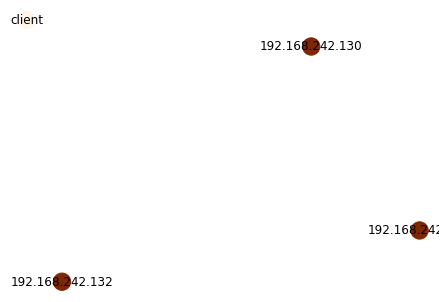

In [5]:
if DEBUG_MODE:
    print(gym_env.environment)
    print(gym_env.action_space)
    print(gym_env.action_space.sample())
    
gym_env.environment.plot_environment_graph()

## Reinforcement Learning Hyperparameters

In [6]:
# Papermill notebook parameters

env_size = None
iteration_count = 1500
training_episode_count = 20
eval_episode_count = 10
maximum_node_count = 20
maximum_total_credentials = 10

## Reinforcement Learning

In [7]:
# Load gym environment
ep = w.EnvironmentBounds.of_identifiers(
    maximum_node_count=maximum_node_count,
    maximum_total_credentials=maximum_total_credentials,
    identifiers=gym_env.identifiers
)


### Random

In [1]:
gym_env.environment
gym_env.action_space
gym_env.action_space.sample()

import sqlite3
cves = my_ctf.cve_info
for x in cves:
    print(f"here is the CVEs for node {x[0]} :") # query SQL database for CVE information
    for info in x[1]:
        if info != '':
            con = sqlite3.connect("./nvd.db")
            cur = con.cursor()
            con.row_factory = sqlite3.Row
            cur.execute(f"SELECT * FROM nvd where CVE_ID = '{info}'")
            col_name_list = [tuple[0] for tuple in cur.description]
            data = cur.fetchall()
            data = list(data[0])
            print('----------------------')
            for i, j in zip(col_name_list, data):
                print(i +' : ' +j)
            print('----------------------')
#end
"""
## A random agent
"""

for i_episode in range(1):
    observation = gym_env.reset()

    total_reward = 0

    for t in range(5600):
        action = gym_env.sample_valid_action()

        observation, reward, done, info = gym_env.step(action)
        percentage = []
        total_reward += reward
        

        if reward>0:
            print('####### rewarded action: {action}')
            print(f'total_reward={total_reward} reward={reward}')
            gym_env.render()
            
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            print("Environment can be found in plot.html file")
            break


NameError: name 'gym_env' is not defined

In [8]:
gym_env.render()

,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


### Q Learning
Toggle QL in first cell to run

Dev notes: for training and debugging purposes please see below link
https://stackoverflow.com/questions/57507832/unable-to-allocate-array-with-shape-and-data-type

In [9]:
if QL:
    # Evaluate a Tabular Q-learning agent
    tabularq_run = learner.epsilon_greedy_search(
        gym_env,
        ep,
        learner=tqa.QTabularLearner(
            ep,
            gamma=0.015, learning_rate=0.01, exploit_percentile=100),
        episode_count=training_episode_count,
        iteration_count=iteration_count,
        epsilon=0.90,
        epsilon_exponential_decay=5000,
        epsilon_minimum=0.01,
        verbosity=Verbosity.Quiet,
        render=False,
        plot_episodes_length=False,
        render_last_episode_rewards_to='images/ql/ql',
        title="Tabular Q-learning"
    )


In [10]:
if QL:
    gym_env.render()

### Deep Q Learning
Toggle DQL in first cell to run 

In [11]:
if DQL:
    # Evaluate the Deep Q-learning agent
    dql_run = learner.epsilon_greedy_search(
        cyberbattle_gym_env=gym_env,
        environment_properties=ep,
        learner=dqla.DeepQLearnerPolicy(
            ep=ep,
            gamma=0.015,
            replay_memory_size=10000,
            target_update=10,
            batch_size=512,
            # torch default learning rate is 1e-2
            # a large value helps converge in less episodes
            learning_rate=0.01
        ),
        episode_count=training_episode_count,
        iteration_count=iteration_count,
        epsilon=0.90,
        epsilon_exponential_decay=5000,
        epsilon_minimum=0.10,
        verbosity=Verbosity.Quiet,
        render=True,
        plot_episodes_length=False,
        render_last_episode_rewards_to='images/dql/dql',
        title="DQL"
    )

###### DQL
Learning with: episode_count=20,iteration_count=1500,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=5000,γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
  ## Episode: 1/20 'DQL' ϵ=0.9000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 1|Iteration 1500|reward:   33.0|last_reward_at:    6|Elapsed Time: 0:02:16||


  Episode 1 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/151 (0.01)
    explore-remote: 2/645 (0.00)
    explore-connect: 0/625 (0.00)
    exploit-local: 0/19 (0.00)
    exploit-remote: 2/55 (0.04)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 220


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 2/20 'DQL' ϵ=0.6928, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 2|Iteration 1500|reward:   33.0|last_reward_at:   45|Elapsed Time: 0:03:03||


  Episode 2 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/143 (0.01)
    explore-remote: 2/506 (0.00)
    explore-connect: 0/535 (0.00)
    exploit-local: 0/59 (0.00)
    exploit-remote: 2/250 (0.01)
    exploit-connect: 0/2 (0.00)
  exploit deflected to exploration: 257


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 3/20 'DQL' ϵ=0.5391, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 3|Iteration 1500|reward:   33.0|last_reward_at:   22|Elapsed Time: 0:04:14||


  Episode 3 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/117 (0.01)
    explore-remote: 2/471 (0.00)
    explore-connect: 0/481 (0.00)
    exploit-local: 0/64 (0.00)
    exploit-remote: 2/359 (0.01)
    exploit-connect: 0/3 (0.00)
  exploit deflected to exploration: 369


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 4/20 'DQL' ϵ=0.4253, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 4|Iteration 1500|reward:   33.0|last_reward_at:   28|Elapsed Time: 0:04:40||


  Episode 4 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/117 (0.01)
    explore-remote: 2/409 (0.00)
    explore-connect: 0/440 (0.00)
    exploit-local: 0/81 (0.00)
    exploit-remote: 2/448 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 382


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 5/20 'DQL' ϵ=0.3410, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 5|Iteration 1500|reward:   33.0|last_reward_at:   65|Elapsed Time: 1:04:04||


  Episode 5 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/115 (0.00)
    explore-remote: 2/439 (0.00)
    explore-connect: 0/421 (0.00)
    exploit-local: 1/83 (0.01)
    exploit-remote: 2/437 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 518


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 6/20 'DQL' ϵ=0.2785, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 6|Iteration 1500|reward:   33.0|last_reward_at:   46|Elapsed Time: 0:08:21||


  Episode 6 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/106 (0.01)
    explore-remote: 0/413 (0.00)
    explore-connect: 0/387 (0.00)
    exploit-local: 0/103 (0.00)
    exploit-remote: 4/486 (0.01)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 553


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 7/20 'DQL' ϵ=0.2323, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 7|Iteration 1500|reward:   33.0|last_reward_at:   37|Elapsed Time: 0:08:14||


  Episode 7 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/96 (0.00)
    explore-remote: 2/384 (0.01)
    explore-connect: 0/367 (0.00)
    exploit-local: 1/100 (0.01)
    exploit-remote: 2/541 (0.00)
    exploit-connect: 0/7 (0.00)
  exploit deflected to exploration: 511


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 8/20 'DQL' ϵ=0.1980, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 8|Iteration 1500|reward:   33.0|last_reward_at:   15|Elapsed Time: 0:07:28||


  Episode 8 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/88 (0.01)
    explore-remote: 1/331 (0.00)
    explore-connect: 0/375 (0.00)
    exploit-local: 0/121 (0.00)
    exploit-remote: 3/579 (0.01)
    exploit-connect: 0/1 (0.00)
  exploit deflected to exploration: 540


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 9/20 'DQL' ϵ=0.1726, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 9|Iteration 1500|reward:   33.0|last_reward_at:   33|Elapsed Time: 1:18:10||


  Episode 9 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/84 (0.00)
    explore-remote: 4/357 (0.01)
    explore-connect: 0/320 (0.00)
    exploit-local: 1/103 (0.01)
    exploit-remote: 0/631 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 496


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 10/20 'DQL' ϵ=0.1538, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 10|Iteration 1500|reward:   33.0|last_reward_at:   43|Elapsed Time: 0:08:27||


  Episode 10 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/99 (0.00)
    explore-remote: 2/355 (0.01)
    explore-connect: 0/346 (0.00)
    exploit-local: 1/102 (0.01)
    exploit-remote: 2/583 (0.00)
    exploit-connect: 0/10 (0.00)
  exploit deflected to exploration: 584


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 11/20 'DQL' ϵ=0.1398, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 11|Iteration 1500|reward:   33.0|last_reward_at:   21|Elapsed Time: 0:01:12||


  Episode 11 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/35 (0.03)
    explore-remote: 2/133 (0.01)
    explore-connect: 0/126 (0.00)
    exploit-local: 0/215 (0.00)
    exploit-remote: 2/984 (0.00)
    exploit-connect: 0/2 (0.00)
  exploit deflected to exploration: 75


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 12/20 'DQL' ϵ=0.1295, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 12|Iteration 1500|reward:   33.0|last_reward_at:   45|Elapsed Time: 0:01:10||


  Episode 12 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/28 (0.00)
    explore-remote: 1/93 (0.01)
    explore-connect: 0/88 (0.00)
    exploit-local: 1/315 (0.00)
    exploit-remote: 3/971 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 23


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 13/20 'DQL' ϵ=0.1219, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 13|Iteration 1500|reward:   33.0|last_reward_at:   17|Elapsed Time: 0:01:13||


  Episode 13 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/27 (0.00)
    explore-remote: 1/81 (0.01)
    explore-connect: 0/88 (0.00)
    exploit-local: 1/255 (0.00)
    exploit-remote: 3/1044 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 30


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 14/20 'DQL' ϵ=0.1162, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 14|Iteration 1500|reward:   33.0|last_reward_at:   41|Elapsed Time: 0:01:18||


  Episode 14 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/26 (0.00)
    explore-remote: 0/97 (0.00)
    explore-connect: 0/98 (0.00)
    exploit-local: 1/269 (0.00)
    exploit-remote: 4/1005 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 47


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 15/20 'DQL' ϵ=0.1120, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 15|Iteration 1500|reward:   33.0|last_reward_at:   10|Elapsed Time: 0:01:16||


  Episode 15 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/33 (0.00)
    explore-remote: 0/97 (0.00)
    explore-connect: 0/79 (0.00)
    exploit-local: 1/233 (0.00)
    exploit-remote: 4/1053 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 50


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 16/20 'DQL' ϵ=0.1089, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 16|Iteration 1500|reward:   33.0|last_reward_at:   51|Elapsed Time: 0:01:21||


  Episode 16 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/32 (0.00)
    explore-remote: 0/102 (0.00)
    explore-connect: 0/86 (0.00)
    exploit-local: 1/282 (0.00)
    exploit-remote: 4/993 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 37


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 17/20 'DQL' ϵ=0.1066, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 17|Iteration 1500|reward:   33.0|last_reward_at:   14|Elapsed Time: 0:01:20||


  Episode 17 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/24 (0.00)
    explore-remote: 0/101 (0.00)
    explore-connect: 0/92 (0.00)
    exploit-local: 1/257 (0.00)
    exploit-remote: 4/1021 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 53


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 18/20 'DQL' ϵ=0.1049, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 18|Iteration 1500|reward:   33.0|last_reward_at:   18|Elapsed Time: 0:01:17||


  Episode 18 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/24 (0.00)
    explore-remote: 0/81 (0.00)
    explore-connect: 0/96 (0.00)
    exploit-local: 1/259 (0.00)
    exploit-remote: 4/1035 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 41


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 19/20 'DQL' ϵ=0.1036, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 19|Iteration 1500|reward:   33.0|last_reward_at:   18|Elapsed Time: 0:01:19||


  Episode 19 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/18 (0.00)
    explore-remote: 0/87 (0.00)
    explore-connect: 0/97 (0.00)
    exploit-local: 1/269 (0.00)
    exploit-remote: 4/1024 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 48


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]
2,192.168.242.130,owned,[ Windows Server 2016 Standard 14393 (Windows ...,[],[DHCPServerDetection]
3,192.168.242.132,owned,[ Windows Server 2012 R2 Standard 9600 (Window...,[],[SMBSigningnotrequired]


  ## Episode: 20/20 'DQL' ϵ=0.1027, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 20|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

,id,status,properties,local_attacks,remote_attacks
0,client,owned,[CLIENT:Kali],[nmapscan],[mimikatz]
1,192.168.242.128,discovered,NaN,None,[SMBSigningnotrequired]
2,192.168.242.130,discovered,NaN,None,[DHCPServerDetection]
3,192.168.242.132,discovered,NaN,None,[SMBSigningnotrequired]


ValueError: 
The orca executable is required in order to export figures as static images,
but the executable that was found at '/usr/bin/orca'
does not seem to be a valid plotly orca executable. Please refer to the end of
this message for details on what went wrong.

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python

The error encountered is that unexpected output was returned by the command
    $ /usr/bin/orca --help

b'Usage: orca [-h] [-v] [-r] [-s] [-l] [-e OPTION] [-d OPTION] [-p NAME]\n            [-u DIR] [--debug-file FILE] [--debug]\n\nOptional arguments:\n  -h, --help                   Show this help message and exit\n  -v, --version                Version of this application\n  -r, --replace                Replace a currently running instance of this\n                               screen reader\n  -s, --setup                  Set up user preferences (GUI version)\n  -l, --list-apps              Print the known running applications\n  -e OPTION, --enable OPTION   Force use of option\n  -d OPTION, --disable OPTION  Prevent use of option\n  -p NAME, --profile NAME      Load profile\n  -u DIR, --user-prefs DIR     Use alternate directory for user preferences\n  --debug-file FILE            Send debug output to the specified file\n  --debug                      Send debug output to debug-YYYY-MM-DD-\n                               HH:MM:SS.out\n\nReport bugs to orca-list@gnome.org.\n'


In [ ]:
if DQL:
    gym_env.render()

In [ ]:
import pickle

dql_file = "RL_agents/dql.pickle"


if DQL:
    with open(dql_file, 'wb') as handle:
        pickle.dump(dql_run, handle)

"""
with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)
"""

In [ ]:
dql_run


### End of simulation

## Running Trained Agent


In [ ]:
import glob
from PIL import Image
import re

# filepaths
fp_in = "images/old-dql/dql-e20-*.png"
fp_out = "images/dql.gif"


fp_sorted = sorted(glob.glob(fp_in), key=lambda x:int(re.split('[.-]',x)[-2]))
#fp_sorted

#https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.oEpisode 1|Iteration 618|reward:   33.0|last_reward_at:   42|Elapsed Time: 0:00:18||pen(f) for f in fp_sorted]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=1000, loop=0)



In [ ]:
from IPython.display import HTML
HTML('<img src="images/dql.gif">')

In [ ]:
l = dql_run['learner']
epsilon=0.90
step_count = 10000




observation = gym_env.reset()
wrapped_env = AgentWrapper(gym_env, ActionTrackingStateAugmentation(ep, observation))
wrapped_env.render() 

for i in range(step_count):
    observation_old = observation.copy()
    x = np.random.rand()
    if x <= epsilon:
        action_type, action, action_metadata = l.explore(wrapped_env)
    else:
        action_type, action, action_metadata = l.exploit(wrapped_env, observation)
    if not action:
        action_type, action, action_metadata = l.explore(wrapped_env)
    observation, reward, done, info = wrapped_env.step(action)
    if reward > 0:
        wrapped_env.render()
            
            